<a href="https://colab.research.google.com/github/SRI-CSL/signal-public/blob/signal-demonstration/colabs/signal_interest_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SIGNAL**ing Interest Data

**Description:** Generating `interest` dataframe via SIGNAL API.

**Copyright 2022 SRI International.**

This project is under the GPL3 License. See the [LICENSE](https://www.gnu.org/licenses/gpl-3.0.en.html) file for the full license text.

## &#9776; Preamble

Install the `SIGNAL API` client

In [ ]:
!curl https://signal.cta.sri.com/client > client.tgz
!tar xzf client.tgz
!pip install -r signal_api_client/requirements.txt
!pip install -e signal_api_client
!pip install ipympl
%cd /content/signal_api_client   

Download the `funcs` utilities repository.

In [1]:
!git clone https://github.com/hsanchez/funcs.git &> /dev/null

## &#9776; Dependencies

In [2]:
import os
import sys
import time
import warnings

import json
import pickle
import pathlib
import zipfile
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Any, Dict, Tuple
from datetime import date, datetime

In [3]:
os.chdir(f'./funcs')
!git fetch

In [4]:
!git checkout activity_roles_detection_colab &> /dev/null

In [5]:
import funcs as utils

In [6]:
import spacy

In [7]:
from signal_api import signal

## &#9997; Configuration

In [8]:
warnings.filterwarnings("ignore")

In [9]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [10]:
np.random.seed(0)

In [11]:
nlp = spacy.load('en_core_web_sm')

In [12]:
from IPython import get_ipython
utils.common.set_default_vars(os.environ, ipython_val=get_ipython())

In [13]:
utils.console.stdout.print(utils.common.is_run_in_colab())

True

In [14]:
DATA_DICT = {
    "linux-kernel-data.zip": "1h1AGfQkOhvgtcCR8tWVzObBSpBTURWM2",
    "lkml_email_patches_data.zip" : "12V2v3BNjF4RLkvKQZIBEqnBfqxQN1iVK",
    "lkml_content_all.csv": "1iksk8RkfXEk07B5rSoN8JRz_bxukDnuC"
    }

## &#9881; Functions

In [15]:
# B.H. note: Add functions that are not already in funcs here...

In [16]:
def get_record_count(table_name: str) -> int:
    query = f"SELECT COUNT(*) FROM {table_name};"
    df_result = signal.query_dataframe(query)
    result = df_result['count'].iloc[0]
    return result

### &#9759; Bot Analysis Functions

In [17]:
REGEX_GREG_ADDED = re.compile('patch \".*\" added to .*')

BOTS = {'tip-bot2@linutronix.de', 'tipbot@zytor.com', 'tip-bot2@tip-bot2',
        'lkp@ff58d72860ac', 'lkp@shao2-debian', 'lkp@xsang-OptiPlex-9020',
        'rong.a.chen@shao2-debian', 'lkp@b50bd4e4e446', 'rong.a.chen@shao2-debian',
        'noreply@ciplatform.org', 'patchwork@emeril.freedesktop.org',
        'pr-tracker-bot@kernel.org'}
        
POTENTIAL_BOTS = {'broonie@kernel.org', 'lkp@intel.com',
                  'boqun.feng@debian-boqun.qqnc3lrjykvubdpftowmye0fmh.lx.internal.cloudapp.net'}

In [18]:
def is_bot(patch: dict) -> bool:
    email_address = patch['email']
    if email_address in BOTS:
        return True
    
    subject_line = patch.get('subject', '')
    if email_address in POTENTIAL_BOTS:
        # Mark Brown's bot and lkp
        if subject_line.startswith('applied'):
            return True
    sender_name = patch.get('senderName', None)
    sender_name = patch.get('name', '') if sender_name is None else sender_name
    if 'tip-bot2' in sender_name or 'syzbot' in sender_name:
        return True
    if 'tip-bot' in sender_name:
        return True
    if sender_name in POTENTIAL_BOTS:
        return True
    if 'kernel test robot' in sender_name:
        return True
    
    if REGEX_GREG_ADDED.match(subject_line):
        return True
    
    # AKPM's bot. AKPM uses s-nail for automated mails, and sylpheed for all
    # other mails. That's how we can easily separate automated mails from
    # real mails. Further, akpm acts as bot if the subject contains [merged]
    if email_address == 'akpm@linux-foundation.org':
        if '[merged]' in subject_line:
            return True

    # syzbot - email format: syzbot-hash@syzkaller.appspotmail.com
    if 'syzbot' in email_address and 'syzkaller.appspotmail.com' in email_address:
        return True
    
    # Github Bot
    if 'noreply@github.com' in email_address:
        return True
    
    # Buildroot's daily results bot
    if '[autobuild.buildroot.net] daily results' in subject_line or \
        'oe-core cve metrics' in subject_line:
            return True
    
    return False

### &#9759; NLP

In [19]:
def fkre_score(total_words: int, total_sentences: int, total_syllables: int) -> float:
    """Flesch Kincaid Reading Ease (FKRE) score"""

    return round(206.835 - 1.015 * (total_words/total_sentences) - 84.6 * (total_syllables/total_words), 2)

In [20]:
def fkgl_score(total_words: int, total_sentences: int, total_syllables: int) -> float:
    """Flesch Kincaid Grade Level (FKGL) score"""

    return round(0.39 * (total_words/total_sentences) + 11.8 * (total_syllables/total_words) - 15.59, 2)

In [21]:
def count_syllables(word):
    """source: https://codereview.stackexchange.com/questions/224177/python-function-to-count-syllables-in-a-word"""
    return len(
        re.findall('(?!e$)[aeiouy]+', word, re.I) +
        re.findall('^[^aeiouy]*e$', word, re.I)
    )

In [22]:
def message_length(email_body: str) -> int:
    return len(email_body.split("\n"))

In [23]:
def text_to_spacy_nlp(email_body: str):
    """spacy nlp transformation"""
    return nlp(email_body)

In [24]:
def sentence_count(spacy_txt):
    """calculate the number of sentences in an input text
    pre-requisite: run text_to_spacy_nlp() on the original email body
    """
    return len(list(spacy_txt.sents))

In [25]:
def retrieve_words(spacy_txt):
    return [token.text for token in spacy_txt if not token.is_punct]

In [26]:
def word_count(spacy_txt):
    """calculate the number of words in an input text
    pre-requisite: run text_to_spacy_nlp() on the original email body
    """
    return len(retrieve_words(spacy_txt))

## &#128272; Login

In [27]:
signal.login()

username?: ··········
password?: ··········


True

## &#128722; Data

### &#9759; Tables

In [28]:
TABLES_QUERY = "SELECT * FROM information_schema.tables WHERE table_type='BASE TABLE';"

In [29]:
df_tables = signal.query_dataframe(TABLES_QUERY)

In [30]:
table_names = df_tables.table_name.unique()

In [31]:
print(f"There are {len(table_names)} tables currently present in the SIGNAL database.")

There are 87 tables currently present in the SIGNAL database.


In [32]:
df_tables.head()

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,signal,public,scraped_projects,BASE TABLE,None,None,None,None,None,YES,NO,None
1,signal,public,scraped_patch_series,BASE TABLE,None,None,None,None,None,YES,NO,None
2,signal,public,diff,BASE TABLE,None,None,None,None,None,YES,NO,None
3,signal,public,thread,BASE TABLE,None,None,None,None,None,YES,NO,None
4,signal,public,git_files,BASE TABLE,None,None,None,None,None,YES,NO,None


In [33]:
table_names

array(['scraped_projects', 'scraped_patch_series', 'diff', 'thread',
       'git_files', 'email', 'git_commit_edges', 'pg_statistic',
       'pg_type', 'git_file_changes', 'scraped_patches',
       'alembic_version', 'api_key', 'pg_foreign_table', 'pg_authid',
       'signal_history', 'pg_statistic_ext_data', 'git_repos',
       'user_identities', 'person', 'scraped_patch_submitters',
       'mailing_list', 'git_sigs', 'pg_user_mapping', 'pg_subscription',
       'pg_attribute', 'pg_proc', 'pg_class', 'pg_attrdef',
       'pg_constraint', 'pg_inherits', 'pg_index', 'pg_operator',
       'pg_opfamily', 'pg_opclass', 'pg_am', 'pg_amop', 'pg_amproc',
       'pg_language', 'pg_largeobject_metadata', 'pg_aggregate',
       'pg_statistic_ext', 'pg_rewrite', 'pg_trigger', 'pg_event_trigger',
       'pg_description', 'pg_cast', 'pg_enum', 'pg_namespace',
       'pg_conversion', 'pg_depend', 'pg_database', 'pg_db_role_setting',
       'pg_tablespace', 'pg_auth_members', 'pg_shdepend',
       'p

### &#9759; Email Data

In [34]:
START_DATE = datetime(2020, 8, 1)
END_DATE = datetime(2020, 8, 2)

In [35]:
df_email = signal.query_dataframe(f"SELECT * FROM email WHERE timestamp_sent > {START_DATE.timestamp()} and timestamp_sent < {END_DATE.timestamp()};")

In [36]:
df_email.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   276 non-null    int64 
 1   url                  276 non-null    object
 2   mailing_list_id      276 non-null    int64 
 3   email_id             276 non-null    object
 4   message_id           276 non-null    object
 5   reply_to_url         112 non-null    object
 6   author_id            276 non-null    int64 
 7   timestamp_sent       276 non-null    int64 
 8   timestamp_recv       276 non-null    int64 
 9   subject              276 non-null    object
 10  body                 276 non-null    object
 11  clean_body           276 non-null    object
 12  thread_id            276 non-null    object
 13  persuasion           276 non-null    object
 14  reply_to_message_id  276 non-null    object
dtypes: int64(5), object(10)
memory usage: 32.5+ KB


In [37]:
df_email.head()

,id,url,mailing_list_id,email_id,message_id,reply_to_url,author_id,timestamp_sent,timestamp_recv,subject,body,clean_body,thread_id,persuasion,reply_to_message_id
0,30807,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801110231,20200801150050.767038-2-masahiroy@kernel.org,https://lkml.iu.edu/hypermail/linux/kernel/200...,208,1596294151,1596297751,[PATCH 2/2] kbuild: stop filtering out $(GCC_P...,"Commit d26e94149276 (""kbuild: no gcc-plugins d...","Commit d26e94149276 (""kbuild: no gcc-plugins d...",20200801150050.767038-1-masahiroy@kernel.org,Unknown,20200801150050.767038-1-masahiroy@kernel.org
1,30820,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801090629,20200801130856.86625-3-chenzhou10@huawei.com,https://lkml.iu.edu/hypermail/linux/kernel/200...,2724,1596287189,1596290789,[PATCH v11 2/5] x86: kdump: move reserve_crash...,In preparation for supporting reserve_crashker...,In preparation for supporting reserve_crashker...,20200801130856.86625-1-chenzhou10@huawei.com,Unknown,20200801130856.86625-1-chenzhou10@huawei.com
2,31413,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801044951,20200801084721.1812607-4-songliubraving@fb.com,https://lkml.iu.edu/hypermail/linux/kernel/200...,1062,1596271791,1596275391,[PATCH bpf-next 3/5] selftests/bpf: add selfte...,This test checks the correctness of BPF_PROG_T...,This test checks the correctness of BPF_PROG_T...,20200801084721.1812607-1-songliubraving@fb.com,Unknown,20200801084721.1812607-1-songliubraving@fb.com
3,31045,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801130229,636faf6f-4c85-0582-2482-b99002888d0d@kernel.dk,https://lkml.iu.edu/hypermail/linux/kernel/200...,158,1596301349,1596304949,Re: [PATCH] fs: optimise kiocb_set_rw_flags(),"On 8/1/20 4:36 AM, Pavel Begunkov wrote:\n><i>...","On 8/1/20 4:36 AM, Pavel Begunkov wrote:\n><i>...",e523f51f59ad6ecdad4ad22c560cb9c913e96e1a.15962...,Unknown,e523f51f59ad6ecdad4ad22c560cb9c913e96e1a.15962...
4,31061,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801062550,d515fa07-5198-fc3c-24ac-d35aa4e08668@molgen.mp...,None,1977,1596277550,1596281150,Re: xfs_reclaim_inodes_ag taking several seconds,"On 01.08.20 00:32, Dave Chinner wrote:\n<block...","On 01.08.20 00:32, Dave Chinner wrote:\n<block...",8284912e-b99a-31af-1901-a38ea03b8648@molgen.mp...,Unknown,20200731223255.GG2005@dread.disaster.area


**BRILAND NOTE** Check timestamp generation with Tim & Huascar

In [41]:
df_email['sent_time'] = pd.to_datetime(df_email['timestamp_sent'])

In [42]:
df_email.head()

,id,url,mailing_list_id,email_id,message_id,reply_to_url,author_id,timestamp_sent,timestamp_recv,subject,body,clean_body,thread_id,persuasion,reply_to_message_id,sent_time
0,30807,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801110231,20200801150050.767038-2-masahiroy@kernel.org,https://lkml.iu.edu/hypermail/linux/kernel/200...,208,1596294151,1596297751,[PATCH 2/2] kbuild: stop filtering out $(GCC_P...,"Commit d26e94149276 (""kbuild: no gcc-plugins d...","Commit d26e94149276 (""kbuild: no gcc-plugins d...",20200801150050.767038-1-masahiroy@kernel.org,Unknown,20200801150050.767038-1-masahiroy@kernel.org,1970-01-01 00:00:01.596294151
1,30820,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801090629,20200801130856.86625-3-chenzhou10@huawei.com,https://lkml.iu.edu/hypermail/linux/kernel/200...,2724,1596287189,1596290789,[PATCH v11 2/5] x86: kdump: move reserve_crash...,In preparation for supporting reserve_crashker...,In preparation for supporting reserve_crashker...,20200801130856.86625-1-chenzhou10@huawei.com,Unknown,20200801130856.86625-1-chenzhou10@huawei.com,1970-01-01 00:00:01.596287189
2,31413,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801044951,20200801084721.1812607-4-songliubraving@fb.com,https://lkml.iu.edu/hypermail/linux/kernel/200...,1062,1596271791,1596275391,[PATCH bpf-next 3/5] selftests/bpf: add selfte...,This test checks the correctness of BPF_PROG_T...,This test checks the correctness of BPF_PROG_T...,20200801084721.1812607-1-songliubraving@fb.com,Unknown,20200801084721.1812607-1-songliubraving@fb.com,1970-01-01 00:00:01.596271791
3,31045,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801130229,636faf6f-4c85-0582-2482-b99002888d0d@kernel.dk,https://lkml.iu.edu/hypermail/linux/kernel/200...,158,1596301349,1596304949,Re: [PATCH] fs: optimise kiocb_set_rw_flags(),"On 8/1/20 4:36 AM, Pavel Begunkov wrote:\n><i>...","On 8/1/20 4:36 AM, Pavel Begunkov wrote:\n><i>...",e523f51f59ad6ecdad4ad22c560cb9c913e96e1a.15962...,Unknown,e523f51f59ad6ecdad4ad22c560cb9c913e96e1a.15962...,1970-01-01 00:00:01.596301349
4,31061,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801062550,d515fa07-5198-fc3c-24ac-d35aa4e08668@molgen.mp...,None,1977,1596277550,1596281150,Re: xfs_reclaim_inodes_ag taking several seconds,"On 01.08.20 00:32, Dave Chinner wrote:\n<block...","On 01.08.20 00:32, Dave Chinner wrote:\n<block...",8284912e-b99a-31af-1901-a38ea03b8648@molgen.mp...,Unknown,20200731223255.GG2005@dread.disaster.area,1970-01-01 00:00:01.596277550


In [38]:
total_email_records = get_record_count(table_name='email')
print(f"In total, there are {total_email_records:,} email records in the database.")

In total, there are 73,069 email records in the database.


### &#9759; Patches Data

In [43]:
total_patch_records = get_record_count(table_name='scraped_patches')
print(f"In total, there are {total_patch_records:,} patch records in the database.")

In total, there are 938,137 patch records in the database.


In [44]:
df_patches = signal.query_dataframe(f"SELECT * FROM scraped_patches;")

In [45]:
df_patches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938137 entries, 0 to 938136
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             938137 non-null  int64  
 1   project_id     938137 non-null  int64  
 2   patch_id       938137 non-null  int64  
 3   mail_id        938137 non-null  object 
 4   name           938137 non-null  object 
 5   series_id      935162 non-null  float64
 6   ack_count      938137 non-null  int64  
 7   review_count   938137 non-null  int64  
 8   tested_count   938137 non-null  int64  
 9   success_count  938137 non-null  int64  
 10  warning_count  938137 non-null  int64  
 11  fail_count     938137 non-null  int64  
 12  date           938137 non-null  object 
 13  submitter_id   938137 non-null  int64  
 14  delegate       125878 non-null  object 
 15  state          938137 non-null  object 
 16  commit_hash    0 non-null       object 
dtypes: float64(1), int64(10), obj

In [46]:
df_patches.head()

,id,project_id,patch_id,mail_id,name,series_id,ack_count,review_count,tested_count,success_count,warning_count,fail_count,date,submitter_id,delegate,state,commit_hash
0,1,1,11614315,20200619142922.GA267142@mwanda,[net-next] ath11k: fix uninitialized return in...,1.0,0,0,0,0,0,0,2020-06-19T00:00:00,1,None,New,None
1,2,1,11611413,1592458104-2961-4-git-send-email-akolli@codeau...,"[v3,3/3] ath11k: add IPQ6018 support",2.0,0,0,0,0,0,0,2020-06-18T00:00:00,2,None,New,None
2,3,1,11611417,1592458104-2961-3-git-send-email-akolli@codeau...,"[v3,2/3] ath11k: copy ce service configs to hw...",2.0,0,0,0,0,0,0,2020-06-18T00:00:00,2,None,New,None
3,4,1,11611415,1592458104-2961-2-git-send-email-akolli@codeau...,"[v3,1/3] dt: bindings: net: update compatible ...",2.0,0,0,0,0,0,0,2020-06-18T00:00:00,2,None,New,None
4,5,1,11610073,20200617150021.4183253-3-john@phrozen.org,[3/3] ath11k: add support for BSS coloring,3.0,0,0,0,0,0,0,2020-06-17T00:00:00,3,None,New,None


In [47]:
tmp_state = df_patches.groupby(df_patches['state']).size().sort_values()
tmp_state

state
Needs ACK                48
In Next                 124
Under Review            744
Queued                  941
Rejected               2136
Deferred               4252
RFC                    6300
Awaiting Upstream      7308
Handled Elsewhere      7809
Mainlined             14739
Changes Requested     26867
Not Applicable        49217
Accepted              91480
Superseded           135830
New                  590342
dtype: int64

<AxesSubplot:title={'center':'Patch State Records'}, ylabel='State'>

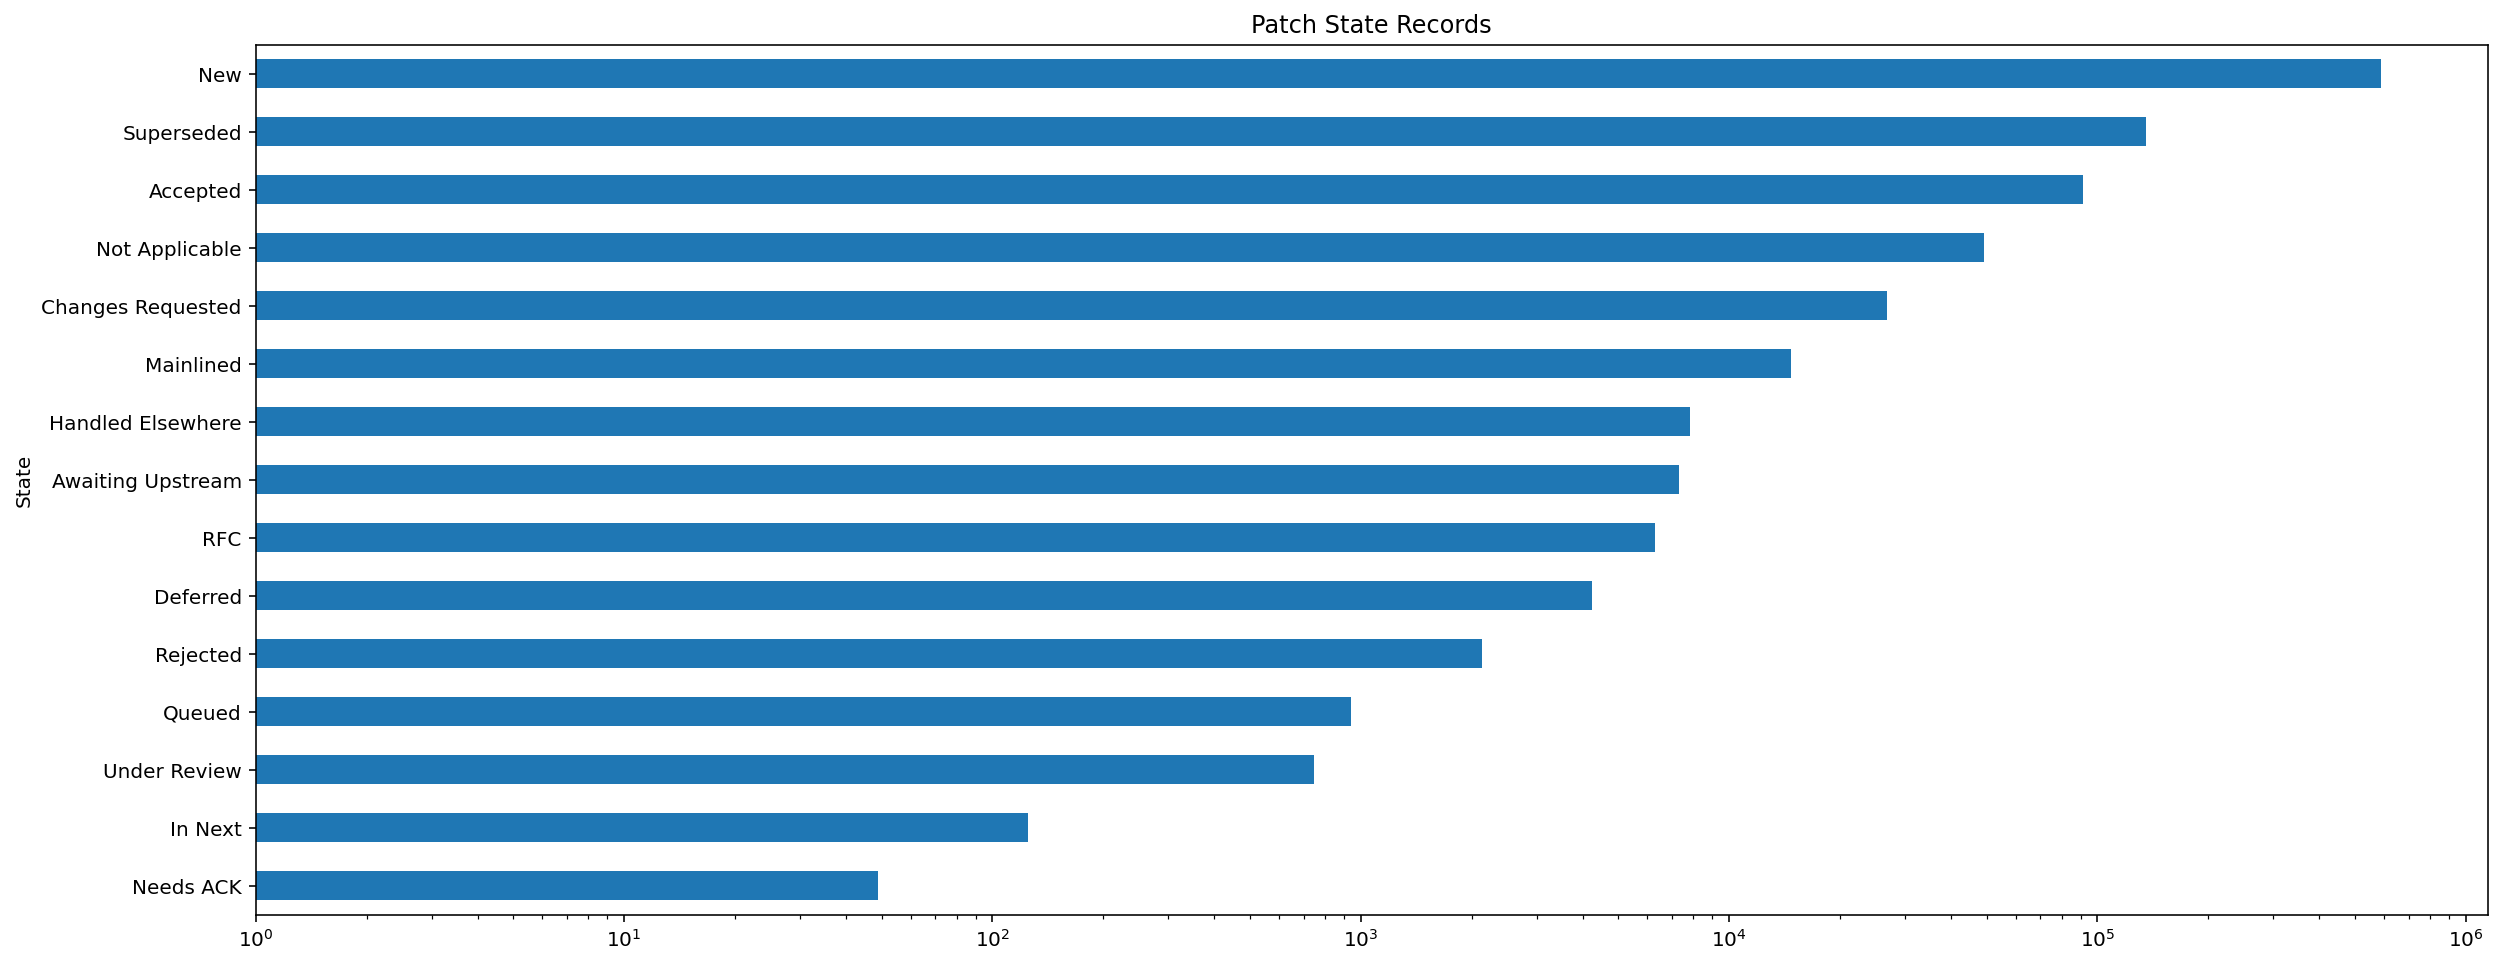

In [51]:
tmp_state.plot.barh(title="Patch State Records", xlabel="State", ylabel="Number of records", log=True, figsize=(20,8))

<font color='red'>The cells below correspond to the lkmlByPatches.csv data and are to be removed/replaced with the corresponding SIGNAL API queries once the later become available.</font>

In [13]:
# patch data
patches_data_file = utils.gdrive.get_dataset(dataset_name='lkml_email_patches_data.zip', is_local_file=False, name2gdid=DATA_DICT)

In [14]:
patches_data_file

'/content/funcs/lkml_email_patches_data.zip'

In [15]:
with zipfile.ZipFile(f'{patches_data_file}', 'r') as lk_data:
    lk_data.extractall('./lkml_data')

In [16]:
path_patches_data = os.path.join(os.getcwd(), 'lkml_data', 'lkml_email_patches_data', 'lkmlByPatches.csv')
path_patches_data

'/content/funcs/lkml_data/lkml_email_patches_data/lkmlByPatches.csv'

In [17]:
df_lkmlby_patches = pd.read_csv(path_patches_data)

In [18]:
df_lkmlby_patches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130864 entries, 0 to 130863
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         130864 non-null  int64  
 1   project    130864 non-null  object 
 2   date       130864 non-null  float64
 3   filename   130861 non-null  object 
 4   msgid      130864 non-null  object 
 5   name       130861 non-null  object 
 6   state      130864 non-null  object 
 7   submitter  130864 non-null  object 
 8   commit     61482 non-null   object 
 9   hash       128369 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 10.0+ MB


In [19]:
df_lkmlby_patches.head()

,id,project,date,filename,msgid,name,state,submitter,commit,hash
0,11052191,Linux Wireless Mailing List,1.563820e+09,v4-1-3-nl80211-Update-uapi-for-CMD_FRAME_WAIT_...,<20190722113312.14031-1-denkenz@gmail.com>,"[v4,1/3] nl80211: Update uapi for CMD_FRAME_WA...",Accepted,Denis Kenzior <denkenz@gmail.com>,NaN,08322f85498bd5735275bf3626194d531bd58d05
1,11052195,Linux Wireless Mailing List,1.563820e+09,v4-3-3-nl80211-Include-wiphy-address-setup-in-...,<20190722113312.14031-3-denkenz@gmail.com>,"[v4,3/3] nl80211: Include wiphy address setup ...",Accepted,Denis Kenzior <denkenz@gmail.com>,NaN,678efa2da3b96691e9fc11fdb1eadc10e2184f7e
2,11117603,Linux Wireless Mailing List,1.566971e+09,1-2-mac80211-Don-t-memset-RXCB-prior-to-PAE-in...,<20190827224120.14545-2-denkenz@gmail.com>,[1/2] mac80211: Don't memset RXCB prior to PAE...,Accepted,Denis Kenzior <denkenz@gmail.com>,NaN,2905c51a09ce9680eaadea6fc37c4319b31a6f79
3,11117605,Linux Wireless Mailing List,1.566971e+09,2-2-mac80211-Correctly-set-noencrypt-for-PAE-f...,<20190827224120.14545-3-denkenz@gmail.com>,[2/2] mac80211: Correctly set noencrypt for PA...,Accepted,Denis Kenzior <denkenz@gmail.com>,NaN,4a8754dda8a4f5ed5b21dfc977d10bb70b9baf29
4,11119923,Linux Wireless Mailing List,1.567052e+09,cfg80211-Purge-frame-registrations-on-iftype-c...,<20190828211110.15005-1-denkenz@gmail.com>,cfg80211: Purge frame registrations on iftype ...,Accepted,Denis Kenzior <denkenz@gmail.com>,NaN,eda432593b03a9194e82df03f61bc8b83087b32d


In [20]:
# projectID
df_lkmlby_patches['projectID'] = df_lkmlby_patches['project'].factorize()[0]

In [21]:
# stateID
df_lkmlby_patches['stateID'] = df_lkmlby_patches['state'].factorize()[0]

In [22]:
df_lkmlby_patches.drop_duplicates(inplace=True)

In [23]:
df_lkmlby_patches.head()

,id,project,date,filename,msgid,name,state,submitter,commit,hash,projectID,stateID
0,11052191,Linux Wireless Mailing List,1.563820e+09,v4-1-3-nl80211-Update-uapi-for-CMD_FRAME_WAIT_...,<20190722113312.14031-1-denkenz@gmail.com>,"[v4,1/3] nl80211: Update uapi for CMD_FRAME_WA...",Accepted,Denis Kenzior <denkenz@gmail.com>,NaN,08322f85498bd5735275bf3626194d531bd58d05,0,0
1,11052195,Linux Wireless Mailing List,1.563820e+09,v4-3-3-nl80211-Include-wiphy-address-setup-in-...,<20190722113312.14031-3-denkenz@gmail.com>,"[v4,3/3] nl80211: Include wiphy address setup ...",Accepted,Denis Kenzior <denkenz@gmail.com>,NaN,678efa2da3b96691e9fc11fdb1eadc10e2184f7e,0,0
2,11117603,Linux Wireless Mailing List,1.566971e+09,1-2-mac80211-Don-t-memset-RXCB-prior-to-PAE-in...,<20190827224120.14545-2-denkenz@gmail.com>,[1/2] mac80211: Don't memset RXCB prior to PAE...,Accepted,Denis Kenzior <denkenz@gmail.com>,NaN,2905c51a09ce9680eaadea6fc37c4319b31a6f79,0,0
3,11117605,Linux Wireless Mailing List,1.566971e+09,2-2-mac80211-Correctly-set-noencrypt-for-PAE-f...,<20190827224120.14545-3-denkenz@gmail.com>,[2/2] mac80211: Correctly set noencrypt for PA...,Accepted,Denis Kenzior <denkenz@gmail.com>,NaN,4a8754dda8a4f5ed5b21dfc977d10bb70b9baf29,0,0
4,11119923,Linux Wireless Mailing List,1.567052e+09,cfg80211-Purge-frame-registrations-on-iftype-c...,<20190828211110.15005-1-denkenz@gmail.com>,cfg80211: Purge frame registrations on iftype ...,Accepted,Denis Kenzior <denkenz@gmail.com>,NaN,eda432593b03a9194e82df03f61bc8b83087b32d,0,0


In [24]:
df_lkmlby_patches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54932 entries, 0 to 130822
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         54932 non-null  int64  
 1   project    54932 non-null  object 
 2   date       54932 non-null  float64
 3   filename   54930 non-null  object 
 4   msgid      54932 non-null  object 
 5   name       54930 non-null  object 
 6   state      54932 non-null  object 
 7   submitter  54932 non-null  object 
 8   commit     24964 non-null  object 
 9   hash       53819 non-null  object 
 10  projectID  54932 non-null  int64  
 11  stateID    54932 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 5.4+ MB


In [25]:
df_lkmlby_patches.date.min(), df_lkmlby_patches.date.max()

(1546296174.0, 1625121590.0)

In [26]:
df_lkmlby_patches['date'] = pd.to_datetime(df_lkmlby_patches['date'], utc=True)

In [33]:
df_lkmlby_patches.date.min(), df_lkmlby_patches.date.max()

(Timestamp('1970-01-01 00:00:01.546296174+0000', tz='UTC'),
 Timestamp('1970-01-01 00:00:01.625121590+0000', tz='UTC'))

In [28]:
df_lkmlby_patches = df_lkmlby_patches.sort_values(by=['date'])

In [30]:
df_lkmlby_patches.head()

,id,project,date,filename,msgid,name,state,submitter,commit,hash,projectID,stateID
104353,10745399,Linux Wireless Mailing List,1970-01-01 00:00:01.546296174+00:00,mt76-dma-avoid-indirect-call-in-mt76_dma_tx_qu...,<c4d933d0332d09c2c2377876c07383691ca50396.1546...,mt76: dma: avoid indirect call in mt76_dma_tx_...,Accepted,Lorenzo Bianconi <lorenzo.bianconi@redhat.com>,NaN,4105f3c4d0060a01c5c3ed898ec562015b5fb2fe,0,0
17359,10745559,XFS devel,1970-01-01 00:00:01.546312728+00:00,xfs_db-fix-finobt-record-decoding-when-sparse-...,<20181231191848.GB20475@magnolia>,xfs_db: fix finobt record decoding when sparse...,Accepted,Darrick J. Wong <darrick.wong@oracle.com>,NaN,4517e7308c61378dd0bf1ab2b2a36f176d4c3b7c,34,0
17360,10745583,XFS devel,1970-01-01 00:00:01.546337319+00:00,2-8-xfs-check-the-ir_startino-alignment-directly,<154630851978.14372.12986942629611980027.stgit...,[2/8] xfs: check the ir_startino alignment dir...,Accepted,Darrick J. Wong <darrick.wong@oracle.com>,NaN,e89f86a7e48a058ab2d5b23be5d42737f4e0aa36,34,0
17361,10745587,XFS devel,1970-01-01 00:00:01.546337332+00:00,4-8-xfs-hoist-inode-cluster-checks-out-of-loop,<154630853205.14372.8548651680958822032.stgit@...,[4/8] xfs: hoist inode cluster checks out of loop,Accepted,Darrick J. Wong <darrick.wong@oracle.com>,NaN,26ae88560baccc1e7d912189957e53cbd16bce4b,34,0
17362,10745589,XFS devel,1970-01-01 00:00:01.546337338+00:00,5-8-xfs-clean-up-the-inode-cluster-checking-in...,<154630853834.14372.13119540305623771045.stgit...,[5/8] xfs: clean up the inode cluster checking...,Accepted,Darrick J. Wong <darrick.wong@oracle.com>,NaN,c7639e8ee64fa530cc194fd7fb69795b152f7371,34,0


In [31]:
df_lkmlby_patches.tail()

,id,project,date,filename,msgid,name,state,submitter,commit,hash,projectID,stateID
60638,12352865,Netdev + BPF,1970-01-01 00:00:01.625116948+00:00,net-v2-3-6-net-dsa-mv88e6xxx-enable-.rmu_disab...,<20210630222231.2297-4-kabel@kernel.org>,"[net,v2,3/6] net: dsa: mv88e6xxx: enable .rmu_...",Accepted,Marek BehÃºn <kabel@kernel.org>,NaN,665812b5081bad631774ce2b705cda9b4a51e63d,9,0
60639,12352863,Netdev + BPF,1970-01-01 00:00:01.625116949+00:00,net-v2-4-6-net-dsa-mv88e6xxx-enable-devlink-AT...,<20210630222231.2297-5-kabel@kernel.org>,"[net,v2,4/6] net: dsa: mv88e6xxx: enable devli...",Accepted,Marek BehÃºn <kabel@kernel.org>,NaN,737f803f4b8d5a18328bd719bc21f0159fac6f36,9,0
60640,12352867,Netdev + BPF,1970-01-01 00:00:01.625116950+00:00,net-v2-5-6-net-dsa-mv88e6xxx-enable-SerDes-RX-...,<20210630222231.2297-6-kabel@kernel.org>,"[net,v2,5/6] net: dsa: mv88e6xxx: enable SerDe...",Accepted,Marek BehÃºn <kabel@kernel.org>,NaN,0040078c1baa7936e362b1e34ac9220adede9f1e,9,0
60641,12352869,Netdev + BPF,1970-01-01 00:00:01.625116951+00:00,net-v2-6-6-net-dsa-mv88e6xxx-enable-SerDes-PCS...,<20210630222231.2297-7-kabel@kernel.org>,"[net,v2,6/6] net: dsa: mv88e6xxx: enable SerDe...",Accepted,Marek BehÃºn <kabel@kernel.org>,NaN,ae5dbba75baf6096b42304f372a40dccc858a283,9,0
30546,12352955,Kernel Selftest,1970-01-01 00:00:01.625121590+00:00,kunit-tool-Fix-error-messages-for-cases-of-no-...,<20210630233950.1638536-1-rmoar@google.com>,kunit: tool: Fix error messages for cases of n...,Accepted,Rae Moar <rmoar@google.com>,ed01ad3a2fac8fff63f441ead4f8653da053c65b,613d1a4afbc3e834da1173b0bfc2c6ad21667d53,8,0


<font color='red'>END OF lkmlByPatches.csv DATA</font>

## &#129504; Generate Interest Data

Features of interest:

```python
['fkre_score',
 'fkgl_score',
 'message_exper',
 'commit_exper',
 'word_cnt',
 'sentence_cnt',
 'exert_influence',
 'patch_email',
 'first_patch_thread',
 'sent_time',
 'received_time',
 'reply_within_4hr',
 'patch_churn',
 'bug_fix',
 'new_feature',
 'accepted_patch',
 'accepted_commit']
 ```

### &#9759; Exert Influence Feature

In [52]:
# Based on the persuasion strategies in 
# Wang, X., Shi, W., Kim, R., Oh, Y., Yang, S., Zhang, J., & Yu, Z. (2019). 
# Persuasion for good: Towards a personalized persuasive dialogue system for social good.
# arXiv preprint [arXiv:1906.06725](https://arxiv.org/abs/1906.06725) 
persuasion_label = dict({
    0: 'task-related-inquiry', 
    1: 'credibility-appeal', 
    2: 'logical-appeal', 
    3: 'personal-related-inquiry', 
    4: 'source-related-inquiry', 
    5: 'donation-information', 
    6: 'foot-in-the-door', 
    7: 'emotion-appeal', 
    8: 'self-modeling', 
    9: 'personal-story',
    10: 'Unknown'})

In [53]:
# all persuasion strategies - the unknown one
persuasion_set = persuasion_label.keys() - {10}
persuasion_set

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [54]:
# exert influence through persuasion
df_email['exert_influence'] = df_email['persuasion'].apply(lambda x: 1 if (x in persuasion_set) else 0)

In [55]:
tmp_influence = df_email.groupby(df_email['exert_influence']).size().sort_values()
tmp_influence

exert_influence
0    276
dtype: int64

<AxesSubplot:title={'center':'Influence Records'}, ylabel='Influence'>

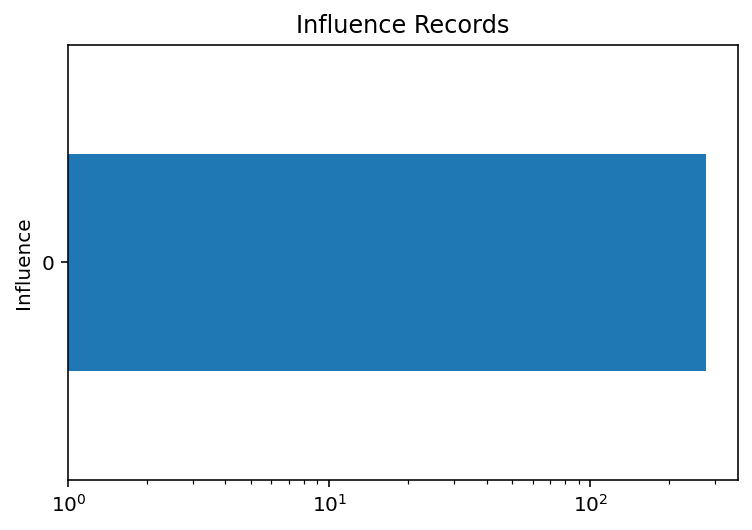

In [56]:
tmp_influence.plot.barh(title="Influence Records", xlabel="Influence", ylabel="Number of records", log=True)

### &#9759; NLP Features

* fkre_score
* fkgl_score
* message_exper
* commit_exper
* word_cnt
* sentence_cnt

#### &#9759; Test

In [57]:
email_0 = df_email.loc[0]

In [58]:
email_0

id                                                                 30807
url                    https://lkml.iu.edu/hypermail/linux/kernel/200...
mailing_list_id                                                        1
email_id                                                  20200801110231
message_id                  20200801150050.767038-2-masahiroy@kernel.org
reply_to_url           https://lkml.iu.edu/hypermail/linux/kernel/200...
author_id                                                            208
timestamp_sent                                                1596294151
timestamp_recv                                                1596297751
subject                [PATCH 2/2] kbuild: stop filtering out $(GCC_P...
body                   Commit d26e94149276 ("kbuild: no gcc-plugins d...
clean_body             Commit d26e94149276 ("kbuild: no gcc-plugins d...
thread_id                   20200801150050.767038-1-masahiroy@kernel.org
persuasion                                         

In [59]:
txt_to_spacy = text_to_spacy_nlp(email_body=email_0.clean_body)

In [60]:
txt_to_spacy

Commit d26e94149276 ("kbuild: no gcc-plugins during cc-option tests")
was neeeded because scripts/Makefile.gcc-plugins was too early.

This is unneeded by including scripts/Makefile.gcc-plugins last,
and being careful to not add cc-option tests after it.

Signed-off-by: Masahiro Yamada <masahiroy@xxxxxxxxxx>

-- 
2.25.1



In [61]:
sentence_cnt = sentence_count(spacy_txt=txt_to_spacy)
sentence_cnt

3

In [62]:
word_cnt = word_count(spacy_txt=txt_to_spacy)
word_cnt

55

In [63]:
syllables_cnt = sum([count_syllables(s) for s in retrieve_words(spacy_txt=txt_to_spacy)])
syllables_cnt

74

#### &#9759; Deployment

In [64]:
df_email['txt_to_spacy'] = df_email.apply(lambda row: text_to_spacy_nlp(email_body=row.clean_body), axis=1)

In [65]:
df_email['sentence_cnt'] = df_email.apply(lambda row: sentence_count(spacy_txt=row.txt_to_spacy), axis=1)

In [66]:
df_email['word_cnt'] = df_email.apply(lambda row: word_count(spacy_txt=row.txt_to_spacy), axis=1)

In [67]:
df_email['syllables_cnt'] = df_email.apply(lambda row: sum([count_syllables(s) for s in retrieve_words(spacy_txt=row.txt_to_spacy)]), axis=1)

In [68]:
df_email['fkre_score'] = df_email.apply(lambda row: fkre_score(
    total_words=row.word_cnt, 
    total_sentences=row.sentence_cnt, 
    total_syllables=row.syllables_cnt), axis=1)

In [69]:
df_email['fkgl_score'] = df_email.apply(lambda row: fkgl_score(
    total_words=row.word_cnt, 
    total_sentences=row.sentence_cnt, 
    total_syllables=row.syllables_cnt), axis=1)

In [70]:
df_email.head()

,id,url,mailing_list_id,email_id,message_id,reply_to_url,author_id,timestamp_sent,timestamp_recv,subject,...,persuasion,reply_to_message_id,sent_time,exert_influence,txt_to_spacy,sentence_cnt,word_cnt,syllables_cnt,fkre_score,fkgl_score
0,30807,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801110231,20200801150050.767038-2-masahiroy@kernel.org,https://lkml.iu.edu/hypermail/linux/kernel/200...,208,1596294151,1596297751,[PATCH 2/2] kbuild: stop filtering out $(GCC_P...,...,Unknown,20200801150050.767038-1-masahiroy@kernel.org,1970-01-01 00:00:01.596294151,0,"(Commit, d26e94149276, (, "", kbuild, :, no, gc...",3,55,74,74.40,7.44
1,30820,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801090629,20200801130856.86625-3-chenzhou10@huawei.com,https://lkml.iu.edu/hypermail/linux/kernel/200...,2724,1596287189,1596290789,[PATCH v11 2/5] x86: kdump: move reserve_crash...,...,Unknown,20200801130856.86625-1-chenzhou10@huawei.com,1970-01-01 00:00:01.596287189,0,"(In, preparation, for, supporting, reserve_cra...",4,57,73,84.02,5.08
2,31413,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801044951,20200801084721.1812607-4-songliubraving@fb.com,https://lkml.iu.edu/hypermail/linux/kernel/200...,1062,1596271791,1596275391,[PATCH bpf-next 3/5] selftests/bpf: add selfte...,...,Unknown,20200801084721.1812607-1-songliubraving@fb.com,1970-01-01 00:00:01.596271791,0,"(This, test, checks, the, correctness, of, BPF...",2,41,54,74.60,7.95
3,31045,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801130229,636faf6f-4c85-0582-2482-b99002888d0d@kernel.dk,https://lkml.iu.edu/hypermail/linux/kernel/200...,158,1596301349,1596304949,Re: [PATCH] fs: optimise kiocb_set_rw_flags(),...,Unknown,e523f51f59ad6ecdad4ad22c560cb9c913e96e1a.15962...,1970-01-01 00:00:01.596301349,0,"(On, 8/1/20, 4:36, AM, ,, Pavel, Begunkov, wro...",4,55,57,105.20,2.00
4,31061,https://lkml.iu.edu/hypermail/linux/kernel/200...,1,20200801062550,d515fa07-5198-fc3c-24ac-d35aa4e08668@molgen.mp...,None,1977,1596277550,1596281150,Re: xfs_reclaim_inodes_ag taking several seconds,...,Unknown,20200731223255.GG2005@dread.disaster.area,1970-01-01 00:00:01.596277550,0,"(On, 01.08.20, 00:32, ,, Dave, Chinner, wrote,...",29,1005,1171,73.09,11.67


### &#9759; Patch Email Feature

In [71]:
def check_if_patch(w):
    """https://stackoverflow.com/questions/5319922/python-check-if-word-is-in-a-string"""
    return re.compile(r'\b({0})\b'.format(w), flags=re.IGNORECASE).search

In [72]:
df_email['patch_email'] = df_email.apply(lambda row: 1 if check_if_patch("patch")(row['subject']) else 0, axis=1)

In [74]:
tmp_patch_email = df_email.groupby(df_email['patch_email']).size().sort_values()
tmp_patch_email

patch_email
0     34
1    242
dtype: int64

### &#9759; Patch Churn Feature

In [90]:
df_email['patch_churn'] = df_email.apply(lambda row: 1 if check_if_patch("patch")(row['subject']) else 0, axis=1)

### &#9759; Bug Fix Feature

In [91]:
# is_bug_fix = is_patch_churn
# is_new_feature = is_patch_churn
df_email['bug_fix'] = df_email.apply(lambda row: 1 if row['patch_churn'] == 1 else 0, axis=1)

### &#9759; New Feature

In [92]:
df_email['new_feature'] = df_email.apply(lambda row: 1 if row['patch_churn'] == 1 else 0, axis=1)

### &#9759; First Patch Thread Feature

In [ ]:
# thread_id: 20200801150050.767038-1-masahiroy@kernel.org

# ORIGINAL LOGIC: CHECK WITH HUASCAR
# is_first_patch_thread = 1 if not np.isnan(row['thread']) else 0

In [88]:
df_email['first_patch_thread'] = df_email.apply(lambda row: 1 if row['thread_id'] and not row['reply_to_message_id'] else 0, axis=1)

In [89]:
tmp_first_patch_thread = df_email.groupby(df_email['first_patch_thread']).size().sort_values()
tmp_first_patch_thread

first_patch_thread
1     67
0    209
dtype: int64

### &#9759; Accepted Patch Feature

In [94]:
def check_if_patch_is_accepted(patches_df: pd.DataFrame, patches_df_column: str, message_id: str) -> int:
    """checks if a patch email exists in lkmlByPatches.csv
       return 1 if the patch is accepted
       return 0 if the patch is not accepted
       default 0
    """
    # tmp_msgid = "<" + message_id + ">"
    # res = patches_df[patches_df[patches_df_column].str.contains(message_id)]
    res = patches_df[patches_df[patches_df_column] == message_id]
    if not res.empty:
        # there were cases where multiple rows are returned, 
        # this might be an issue with how lkmlByPatches is constructed
        # getting into consideration only the first row
        # original: if res.state.tolist()[0].casefold() == 'Accepted'.casefold():
        if res.iloc[0].state.casefold() == 'Accepted'.casefold():
            return 1
        else:
            return 0
    else:
        return 0

In [95]:
df_email['accepted_patch'] = df_email.apply(lambda row: check_if_patch_is_accepted(patches_df=df_patches, patches_df_column='mail_id', message_id=row['message_id']), axis=1)

In [96]:
tmp_accepted_patch = df_email.groupby(df_email['accepted_patch']).size().sort_values()
tmp_accepted_patch

accepted_patch
1      5
0    271
dtype: int64

### &#9759; Accepted Commit Feature

In [97]:
def check_if_commit_is_accepted(patches_df: pd.DataFrame, patches_df_column: str, message_id: str) -> int:
    # tmp_msgid = "<" + message_id + ">"
    res = patches_df[patches_df[patches_df_column] == message_id]
    if not res.empty:
        # if str(res.iloc[0].commit) or str(res.iloc[0].hash):
        if str(res.iloc[0].commit_hash):
            return 1
        else:
            return 0
    else:
        return 0

In [98]:
df_email['accepted_commit'] = df_email.apply(lambda row: check_if_commit_is_accepted(patches_df=df_patches, patches_df_column='mail_id', message_id=row['message_id']), axis=1)

In [99]:
tmp_accepted_commit = df_email.groupby(df_email['accepted_commit']).size().sort_values()
tmp_accepted_commit

accepted_commit
1     74
0    202
dtype: int64

### &#9759; reply_within_4hr Feature

In [ ]:
def time_lapsed_in_seconds(email_df, target_email):
    """Given an email search for the earliest email in the dataframe 
       that replies to it and calculate time lapsed in seconds.
       
       TLDR: 
       1. Search for the emails where in_reply_to == email_id
       2. Sort the answer if the returned DF is not empty
       3. Get the earliest response
       4. Do the time difference
       
       return time_lapsed_in_min if reply exists
       return -1 if the email has not received any reply
    """
    tmp_df = email_df[email_df['in_reply_to'] == target_email['emailId']]
    
    if not tmp_df.empty:
#         tmp_df_sorted = sort_emails_by_date(input_df=tmp_df, sort_column='timestampSent')
        tmp_df_sorted = tmp_df.sort_values(by='timestampSent', ascending=True)
#         print(tmp_df_sorted.iloc[0]['timestampSent'], row['timestampSent'])
        time_diff = tmp_df_sorted.iloc[0]['timestampSent'] - row['timestampSent']
        time_lapsed_secs = time_diff.total_seconds()
        return abs(time_lapsed_secs)
    else:
        return -1